## 주식 예측에 도전해 보자  
### ARIMA를 이용한 시계열 데이터 예측
종가 기준 시계열 데이터를 예측한다  


step1. 시계열 데이터 준비  
칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)
  
step2. 각종 전처리 수행  
결측치 처리  
로그 변환  
  
step 3. 시계열 안정성 분석
정성적 그래프 분석
정량적 Augmented Dicky-Fuller Test
시계열 분해(Time Series Decomposition)
Residual 안정성 확인  
  
step4. 학습, 테스트 데이터셋 생성
  
step5. 적정 ARIMA모수 찾기
ACF, PACF 그려보기 -> p,q 구하기
차분 안정성 확인 -> d 구하기  
  
step 6. ARIMA 모델 훈련과 테스트

step 7. 다른 주식 종목 예측해 보기

step 1. 시계열 데이터 준비  
과제의 요구사항은 '종가'를 예측하는 것이다.   

In [20]:
# 필요 모듈 import
import pandas as pd
import numpy as np
import sklearn
import statsmodels
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# 데이터 경로에서 파일 불러오기
data_path='.\ess_data\ARIMA_stock_prediction'
sam_path=os.path.join(data_path, '005930KS.csv')
sam_data=pd.read_csv(sam_path, index_col='Date')
sam_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [22]:
sam_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7+ KB


step2. 각종 전처리 수행  
결측값, 중복값 확인, 처리 및 그래프 관찰과 로그 변환을 진행하였다.

In [23]:
# 결측값 확인
sam_close=sam_data['Close']
sam_close.isna().sum()

0

In [24]:
# 중복값 확인
sam_data.duplicated()[sam_data.duplicated()==True]

Series([], dtype: bool)

<AxesSubplot:xlabel='Close', ylabel='Density'>

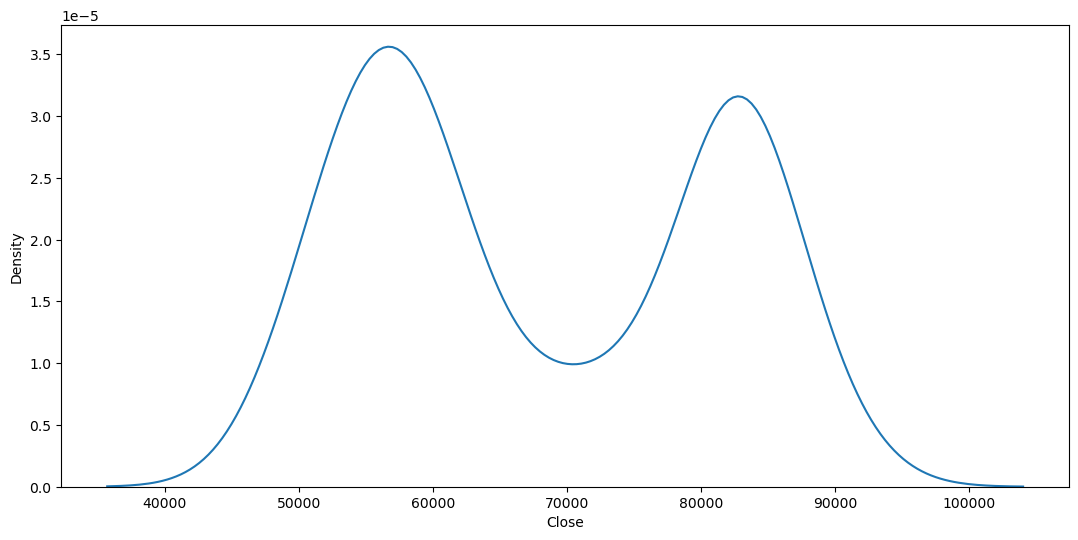

In [25]:
# 그래프 그리기: close만 실행
sns.kdeplot(sam_close)

In [26]:
sam_close

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
               ...   
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, Length: 250, dtype: float64

데이터의 형태에는 문제가 없지만, 데이터 값이 크기 때문에 log를 취해 주었다.

<AxesSubplot:ylabel='Density'>

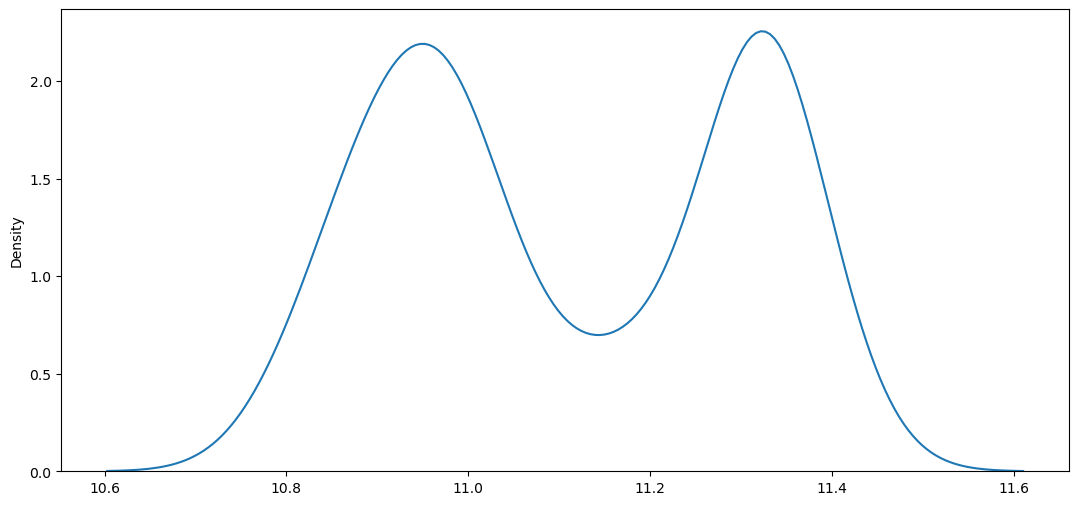

In [27]:
sam_log = np.log1p(sam_close.values)
sns.kdeplot(sam_log)

step 3. 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해(Time Series Decomposition)  
Residual 안정성 확인  

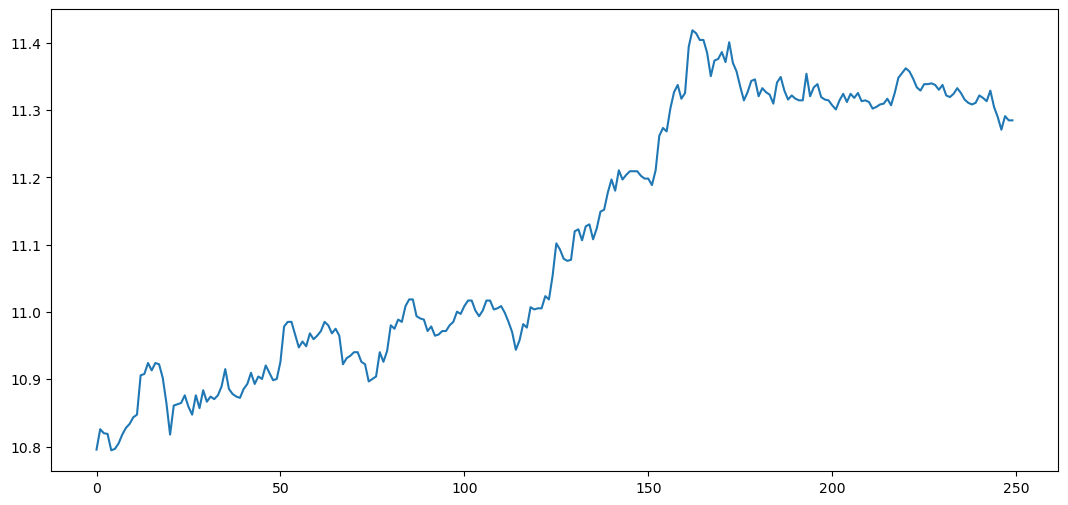

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  
plt.plot(sam_log)